Implementation of a CNN-biGRU model for the detection of human activity in WiFI CSI data.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from datetime import datetime
import os
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import callbacks

# Dataset Path (Google Drive)
dataset_path = '/content/drive/MyDrive/Data/Datasets/Wifi CSI/Room2_npy'

# Data trimming/padding target length
target_length = 750

# Model parameters
Model_type = "Bidirectional GRU-CNN"
batchsize = 128
monitor_choice = 'val_loss'
dropout = 0.2  # Increased dropout for better regularization
learningrate = 0.0005  # Lower learning rate

# List Initialisation
data_list = []
labels_list = []
classes_to_double = ["kneel", "liedown", "pickup"]

# Helper function to split sequences
def split_sequence(sequence, step):
    return [sequence[i:i + step] for i in range(0, len(sequence), step) if len(sequence[i:i + step]) == step]

# Traverse through each activity directory
for activity_folder in os.listdir(dataset_path):
    activity_path = os.path.join(dataset_path, activity_folder)
    if os.path.isdir(activity_path):
        for participant_file in os.listdir(activity_path):
            participant_path = os.path.join(activity_path, participant_file)
            if os.path.isfile(participant_path) and participant_file.endswith('.npy'):
                data = np.load(participant_path)
                data = np.real(data)

                # Split data into smaller sequences
                data_splits = split_sequence(data, target_length)

                for split_data in data_splits:
                    # Normalize data
                    min_val = np.min(split_data)
                    max_val = np.max(split_data)
                    data_normalized = (split_data - min_val) / (max_val - min_val) if max_val != min_val else np.zeros(split_data.shape)

                    label = activity_folder
                    data_list.append(data_normalized)
                    labels_list.append(label)
                    if label in classes_to_double:
                        data_list.append(data_normalized.copy())  # Double the data
                        labels_list.append(label)  # Double the label

# Lists converted to arrays for machine learning processing
data = np.array(data_list)
labels = np.array(labels_list).reshape(-1, 1)

print("Final data shape:", data.shape)
print("Final labels shape:", labels.shape)

# Label Encoding
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels.flatten())
labels_one_hot = to_categorical(labels_encoded)

# Split the data into train and test sets (80% train, 20% test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels_one_hot, test_size=0.2, random_state=42)

# Define the CNN-GRU Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Bidirectional, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

model = Sequential()

# CNN Layer 1: 1D Convolution then MaxPooling
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))

# CNN Layer 2: Additional Convolution layer
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Bidirectional GRU Layer: Bidirectional allows for capturing of more complex relationships
model.add(Bidirectional(GRU(units=256, return_sequences=False, dropout=dropout)))

# Fully Connected Dense Layer
model.add(Dense(512, activation='relu'))
model.add(Dropout(dropout))

# Output Layer: Softmax activation (preferred for multi-class classification)
model.add(Dense(labels_one_hot.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=learningrate), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# To avoid overfitting, implement early stopping
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Set learning rate scheduler details
lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=batchsize, validation_data=(X_test, y_test),
                    verbose=2, callbacks=[early_stopping, lr_scheduler])

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.4f}")


Final data shape: (1814, 750, 90)
Final labels shape: (1814, 1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 748, 64)        │        17,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 374, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 372, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 186, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 512)            │       592,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 901,704 (3.44 MB)

 Trainable params: 901,704 (3.44 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
12/12 - 48s - 4s/step - accuracy: 0.1454 - loss: 2.0690 - val_accuracy: 0.1129 - val_loss: 2.0552 - learning_rate: 5.0000e-04
Epoch 2/50
12/12 - 80s - 7s/step - accuracy: 0.1964 - loss: 2.0253 - val_accuracy: 0.3609 - val_loss: 1.9648 - learning_rate: 5.0000e-04
Epoch 3/50
12/12 - 42s - 4s/step - accuracy: 0.2984 - loss: 1.9065 - val_accuracy: 0.3912 - val_loss: 1.7588 - learning_rate: 5.0000e-04
Epoch 4/50
12/12 - 41s - 3s/step - accuracy: 0.3418 - loss: 1.7398 - val_accuracy: 0.4160 - val_loss: 1.6361 - learning_rate: 5.0000e-04
Epoch 5/50
12/12 - 44s - 4s/step - accuracy: 0.4190 - loss: 1.5823 - val_accuracy: 0.3774 - val_loss: 1.6237 - learning_rate: 5.0000e-04
Epoch 6/50
12/12 - 43s - 4s/step - accuracy: 0.4252 - loss: 1.4996 - val_accuracy: 0.4601 - val_loss: 1.4116 - learning_rate: 5.0000e-04
Epoch 7/50
12/12 - 43s - 4s/step - accuracy: 0.4549 - loss: 1.4004 - val_accuracy: 0.5317 - val_loss: 1.2202 - learning_rate: 5.0000e-04
Epoch 8/50
12/12 - 43s - 4s/step - accura

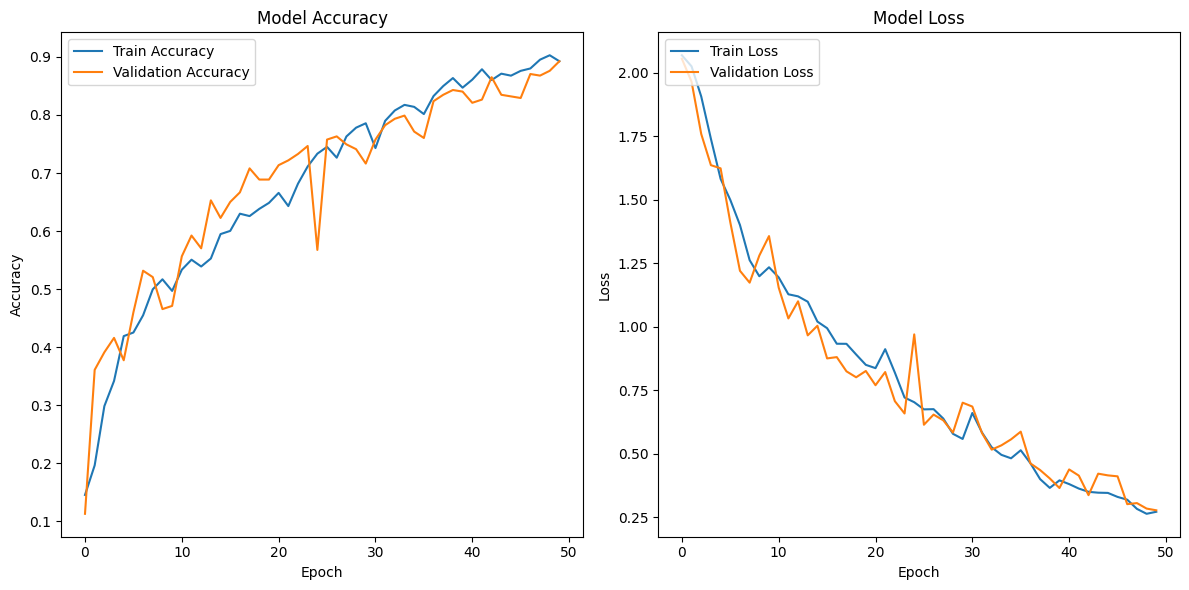

12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 672ms/step


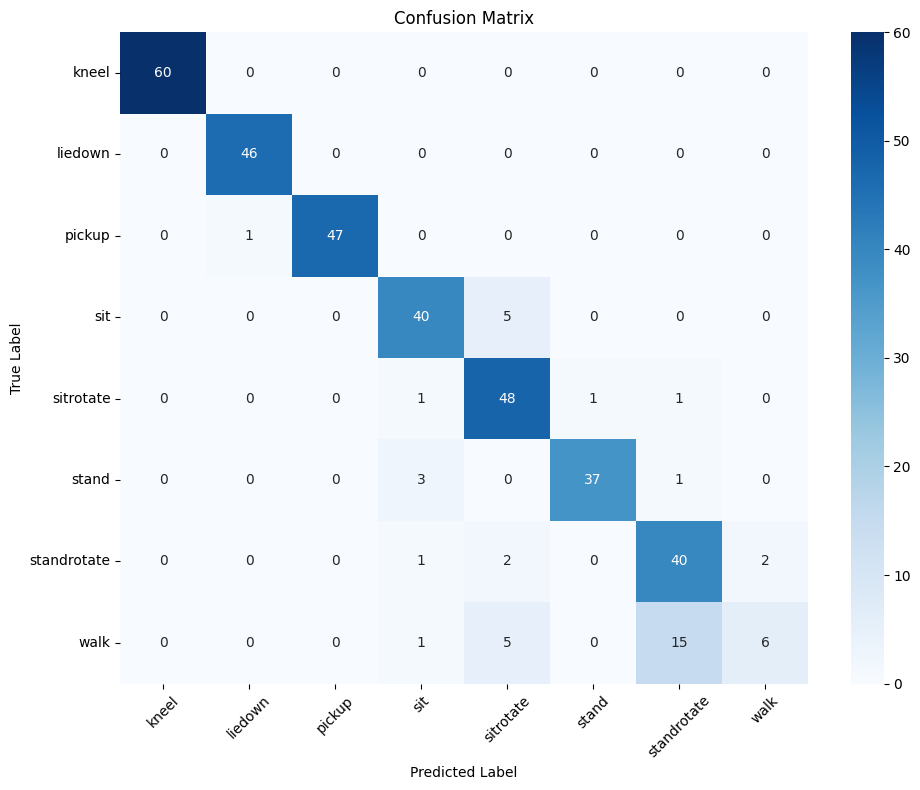

Classification Report:
              precision    recall  f1-score   support

       kneel       1.00      1.00      1.00        60
     liedown       0.98      1.00      0.99        46
      pickup       1.00      0.98      0.99        48
         sit       0.87      0.89      0.88        45
   sitrotate       0.80      0.94      0.86        51
       stand       0.97      0.90      0.94        41
 standrotate       0.70      0.89      0.78        45
        walk       0.75      0.22      0.34        27

    accuracy                           0.89       363
   macro avg       0.88      0.85      0.85       363
weighted avg       0.89      0.89      0.88       363



In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Basic Plots

# Plot training & validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# Confusion Matrix

# Predict classes
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = label_encoder.classes_

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Optional: print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))
